应用系统在日常运行时，会对底层软、硬件造成负荷，影响应用系统性能。本次重点分析存储设备中磁盘容量预测，通过对磁盘容量进行预测，可预测磁盘未来的负载情况，避免应用系统因出现存储容量耗尽的情况导致系统负载率过高，最终引发系统故障。
SYS_NAME:资产所在的系统名称；
NAME:资产名称；
TARGET_ID：属性标识号，183、184分别标识磁盘容量大小和磁盘已使用大小；
DESCRIPTION:针对属性标识的说明；
ENTITY:具体的属性；
VALUE:采集到的值；
COLLECTTIME:采集的时间

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei']#正常显示中文标签
plt.rcParams['axes.unicode_minus']=False#正常显示负号
data=pd.read_excel('./discdata.xls')

In [2]:
pd.to_datetime(data['COLLECTTIME'])
data1=data[(data['ENTITY']=='C:\\') & (data['TARGET_ID']==184)]
data1.set_index('COLLECTTIME',inplace=True)
data2=data[(data['ENTITY']=='D:\\') & (data['TARGET_ID']==184)]
data2.set_index('COLLECTTIME',inplace=True)
print(data.head())
print(data1.head())
print(data2.head())

  SYS_NAME     NAME  TARGET_ID DESCRIPTION ENTITY         VALUE COLLECTTIME
0   财务管理系统  CWXT_DB        184     磁盘已使用大小    C:\  3.427079e+07  2017-10-01
1   财务管理系统  CWXT_DB        184     磁盘已使用大小    D:\  8.026259e+07  2017-10-01
2   财务管理系统  CWXT_DB        183        磁盘容量    C:\  5.232332e+07  2017-10-01
3   财务管理系统  CWXT_DB        183        磁盘容量    D:\  1.572833e+08  2017-10-01
4   财务管理系统  CWXT_DB        184     磁盘已使用大小    C:\  3.432890e+07  2017-10-02
            SYS_NAME     NAME  TARGET_ID DESCRIPTION ENTITY        VALUE
COLLECTTIME                                                             
2017-10-01    财务管理系统  CWXT_DB        184     磁盘已使用大小    C:\  34270787.33
2017-10-02    财务管理系统  CWXT_DB        184     磁盘已使用大小    C:\  34328899.02
2017-10-03    财务管理系统  CWXT_DB        184     磁盘已使用大小    C:\  34327553.50
2017-10-04    财务管理系统  CWXT_DB        184     磁盘已使用大小    C:\  34288672.21
2017-10-05    财务管理系统  CWXT_DB        184     磁盘已使用大小    C:\  34190978.41
            SYS_NAME     NAME  TA

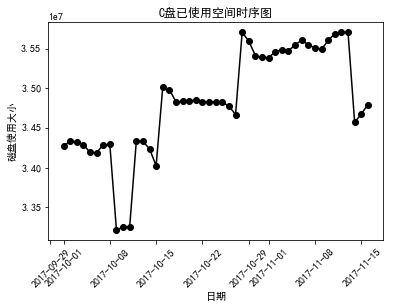

In [3]:
plt.plot(data1.index,data1['VALUE'],'ko-')
plt.title('C盘已使用空间时序图')
plt.xlabel('日期')
plt.ylabel('磁盘使用大小')
plt.xticks(rotation=45)
plt.show()

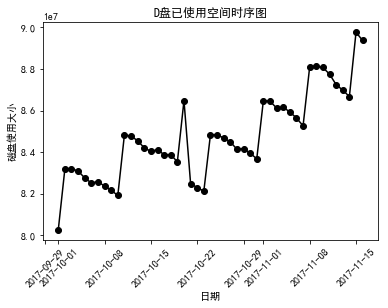

In [4]:
plt.plot(data2.index,data2['VALUE'],'ko-')
plt.title('D盘已使用空间时序图')
plt.xlabel('日期')
plt.ylabel('磁盘使用大小')
plt.xticks(rotation=45)
plt.show()#都不具有平稳性

In [5]:
#数据预处理
data.drop_duplicates(data.columns[:-1],inplace=True)
#属性变换
data3=pd.DataFrame(index=data1.index,columns=['SYS_NAME','CWXT_DB:184:C:\\','CWXT_DB:184:D:\\','COLLECTTIME'])
data3['SYS_NAME']=data1['SYS_NAME']
data3['CWXT_DB:184:C:\\']=data1['VALUE']
data3['CWXT_DB:184:D:\\']=data2['VALUE']
data3['COLLECTTIME']=data1.index
print(data3.head())

            SYS_NAME  CWXT_DB:184:C:\  CWXT_DB:184:D:\ COLLECTTIME
COLLECTTIME                                                       
2017-10-01    财务管理系统      34270787.33      80262592.65  2017-10-01
2017-10-02    财务管理系统      34328899.02      83200151.65  2017-10-02
2017-10-03    财务管理系统      34327553.50      83208320.00  2017-10-03
2017-10-04    财务管理系统      34288672.21      83099271.65  2017-10-04
2017-10-05    财务管理系统      34190978.41      82765171.65  2017-10-05


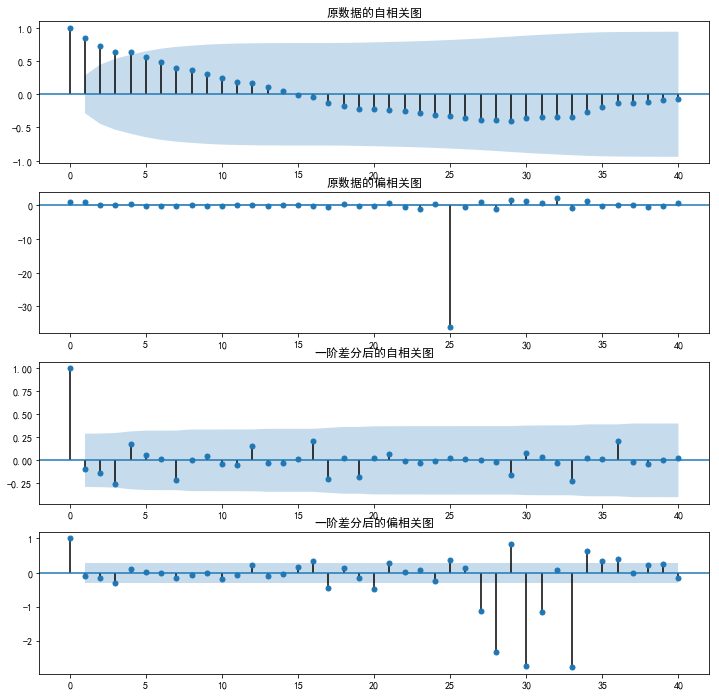

In [6]:
#平稳性检测,通过自相关和偏相关判定平稳性
#如果自相关是拖尾，偏相关截尾，用AR算法
#如果自相关截尾，偏相关拖尾，用MA算法
#如果自相关和偏相关都是拖尾，用ARMA算法
import statsmodels.api as sm
data4=data3['CWXT_DB:184:C:\\']
#绘制原数据的自相关图
fig=plt.figure(figsize=(12,12))
ax1=fig.add_subplot(411)
fig=sm.graphics.tsa.plot_acf(data4,lags=40,ax=ax1)
ax1.set_title('原数据的自相关图')
#绘制原数据的偏相关图
ax2=fig.add_subplot(412)
fig=sm.graphics.tsa.plot_pacf(data4,lags=40,ax=ax2)
ax2.set_title('原数据的偏相关图')
#绘制一阶差分后的自相关图
data4=data4.diff(1).dropna()
ax3=fig.add_subplot(413)
fig=sm.graphics.tsa.plot_acf(data4,lags=40,ax=ax3)
ax3.set_title('一阶差分后的自相关图')
#绘制一阶差分后的偏相关图
ax4=fig.add_subplot(414)
fig=sm.graphics.tsa.plot_pacf(data4,lags=40,ax=ax4)
ax4.set_title('一阶差分后的偏相关图')
plt.show()

In [7]:
data5=data3
data5=data5.iloc[:len(data5)-5]
from statsmodels.tsa.stattools import adfuller as ADF
diff=0
adf=ADF(data5['CWXT_DB:184:D:\\'])
while adf[1]>=0.05:
    diff+=1
    adf=ADF(data5['CWXT_DB:184:D:\\'].diff(diff).dropna())
print('原始序列经过%s阶差分后归于平稳，p值为%s' %(diff,adf[1]))

原始序列经过1阶差分后归于平稳，p值为4.792591263393756e-07


In [8]:
#白噪声检测
#验证序列中有用信息是否已经被提取完毕，需要进行白噪声检验。若序列是白噪声序列，说明序列中有用信息已经被提取完，只剩随机扰动
#采用LB统计量的方法进行白噪声检验,若没有通过白噪声检验，则需要进行模型识别，识别其模型属于AR、MA还是ARMA。
from statsmodels.stats.diagnostic import acorr_ljungbox
[[lb],[p]]=acorr_ljungbox(data5['CWXT_DB:184:D:\\'],lags=1)
if p<0.05:
    print('原始序列为非白噪声序列，对应的p值为：%s' %p)
else:
    print('原始序列为白噪声序列，对应的p值为：%s' %p)
[[lb],[p]]=acorr_ljungbox(data5['CWXT_DB:184:D:\\'].diff().dropna(),lags=1)
if p<0.05:
    print('一阶差分序列为非白噪声序列，对应的p值为：%s' %p)
else:
    print('一阶差分序列为白噪声序列，对应的p值为：%s' %p)

原始序列为非白噪声序列，对应的p值为：9.95850372977218e-06
一阶差分序列为白噪声序列，对应的p值为：0.1143302597764247


In [9]:
#模型识别
'''
step1:采用极大似然比方法进行模型的参数估计，估计各个参数的值。
step2:然后针对各个不同模型，采用信息准则方法（有三种：BIC/AIC/HQ)对模型进行定阶，确定p,q参数，从而选择最优模型。
目前选择模型常用如下准则:
增加自由参数的数目提高了拟合的优良性，AIC/BIC/HQ鼓励数据拟合的优良性但是尽量避免出现过度拟合(Overfitting)的情况。所以优先考虑的模型应是AIC/BIC/HQ值最小的那一个
* AIC = -2 ln(L) + 2 k 中文名字：赤池信息量 akaike information criterion (AIC)
* BIC = -2 ln(L) + ln(n)*k 中文名字：贝叶斯信息量 bayesian information criterion (BIC)
* HQ = -2 ln(L) + ln(ln(n))*k hannan-quinn criterion (HQ)
step3:注意，进行此步时，index需要为时间序列类型
step4:确定最佳p、d、q的值
'''
#确定最佳p,d,q值
data6=pd.read_excel('./discdata_processed.xlsx',index_col='COLLECTTIME')
data6=data6.iloc[:len(data6)-5]
xdata=data6['CWXT_DB:184:D:\\']
from statsmodels.tsa.arima_model import ARIMA
pmax=int(len(xdata)/10)
qmax=int(len(xdata)/10)
bic_matrix=[]
for p in range(qmax+1):
    tmp=[]
    for q in range(pmax+1):
        try:
            tmp.append(ARIMA(xdata,(p,1,q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)
bic_matrix=pd.DataFrame(bic_matrix)
bic_matrix=bic_matrix.astype('float64')
p,q=bic_matrix.stack().idxmin()
print('BIC最小的p值和q值为：%s、%s' %(p,q))

D:\winapps\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\winapps\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\winapps\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\winapps\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\winapps\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\winapps\anaconda\lib\site-packages\st

D:\winapps\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\winapps\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\winapps\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\winapps\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


BIC最小的p值和q值为：1、1


D:\winapps\anaconda\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\winapps\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\winapps\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [10]:
#模型检验
from statsmodels.tsa.arima_model import ARIMA
arima=ARIMA(xdata,(0,1,1)).fit()
xdata_pred=arima.predict(typ='levels')
pred_error=(xdata_pred-xdata).dropna()
from statsmodels.stats.diagnostic import acorr_ljungbox#白噪声检测
lb,p=acorr_ljungbox(pred_error,lags=12)
h=(p<0.05).sum()
if h>0:
    print('模型ARIMA(0,1,1)不符合白噪声检验')
else:
    print('模型ARIMA(0,1,1)符合白噪声检验')

模型ARIMA(0,1,1)符合白噪声检验


D:\winapps\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\winapps\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [11]:
#模型预测
test_predict=arima.forecast(5)[0]
print (test_predict)
#预测对比
test_data=pd.DataFrame(columns=['实际值','预测值'])
test_data['实际值']=data6[(len(data6)-5):]['CWXT_DB:184:D:\\']
test_data['预测值']=test_predict
test_data = test_data.applymap(lambda x: '%.2f' % x)

[88034300.15112542 88217005.85841227 88399711.56569912 88582417.27298597
 88765122.98027281]


In [12]:
# 计算误差  
data7=pd.read_excel('./predictdata.xlsx')
abs_=(data7[u'预测值']-data7[u'实际值']).abs()
mae_=abs_.mean()
rmse_=((abs_**2).mean())
mape_=(abs_/data7[u'实际值']).mean()
print('平均绝对误差为：%.4f,均方误差为：%.4f,平均绝对百分误差为：%.6f' %(mae_,rmse_,mape_))
errors = 1.5  
print ('误差阈值为%s' % errors)
if (mae_ < errors) & (rmse_ < errors) & (mape_ < errors):  
    print ('平均绝对误差为：%.4f, \n均方根误差为：%.4f, \n平均绝对百分误差为：%.4f' % (mae_, rmse_, mape_))  
    print ('误差检验通过！')
else:  
    print ('误差检验不通过！') 

平均绝对误差为：1.1068,均方误差为：1.3744,平均绝对百分误差为：0.012610
误差阈值为1.5
平均绝对误差为：1.1068, 
均方根误差为：1.3744, 
平均绝对百分误差为：0.0126
误差检验通过！
